In [1]:
#Libraries
#nlp
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re, string
import sys
import time
import collections
#nltk.download('stopwords')
#model
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans
from sklearn.model_selection import  train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#plotting
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

import pandas as pd
import numpy as np
import re

%matplotlib inline
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
pd.set_option('float_format', '{:f}'.format)
from ipywidgets import interact


C:\Users\anami\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
#data
yelp_compiled = pd.read_csv('Yelp_data/yelp_compiled_new.csv')
#yelp_compiled_new =pd.read_csv('yelp_data/yelp_compiled_new.csv')
yelp_compiled_tract = pd.read_csv('Yelp_data/yelp_compiled_tract.csv')
#mapping
vegas_geo = pd.read_csv('Yelp_data/vegas_geo.to_csv')
#mapbox access
px.set_mapbox_access_token("pk.eyJ1IjoiYW5hbWlrYTEyMyIsImEiOiJja2Fpb3dycmgwMnJhMnJuc213YnA4emlrIn0.b_ToBPcogxVFLkqiaI9DmA")
vegas_geo['review_score'] = vegas_geo['review_count']*vegas_geo['stars']
vegas_ranked = vegas_geo.sort_values(by=['review_score','price_range'], ascending=[False,True])
#NLP
user_merged = pd.read_csv('Yelp_data//user_merged.csv')
user_merged_high = user_merged[user_merged['income_range']==2]
user_merged_low = user_merged[user_merged['income_range']==0]
high_bad_review = user_merged_high[(user_merged_high.review_stars <= 2 )]
high_good_review = user_merged_high[(user_merged_high.stars >= 4)]
badreviews_only = high_bad_review.text
goodreviews_only = high_good_review.text
low_bad_review = user_merged_low[(user_merged_low.review_stars <= 2 )]
low_good_review = user_merged_low[(user_merged_low.stars >= 4)]
low_badreviews_only = low_bad_review.text
low_goodreviews_only = low_good_review.text

In [3]:
#function for recomender

#kmean
geo = vegas_geo[['longitude','latitude']]
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(geo)   # compute kmeans
y = kmeans.labels_ #labels of each point
#recomender
def recommender(df, longitude, latitude):
    # Predict the cluster for long and lat provided
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print(cluster)
   
    # Get the best restaurant in this cluster
    return  df[df['cluster']==cluster].iloc[0:5][['name', 'address', 'category','price_range', 'stars','income_range']]

In [4]:
#function for word cloud
def tokenize(s):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    return filtered_words
def count_ngrams(lines, min_length=2, max_length=4):
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)
# Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1
# Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()
# Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()
    return ngrams
def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-word phrase -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')
def print_word_cloud(ngrams, num=5):
    """Print word cloud image plot """
    words = []
    for n in sorted(ngrams):
        for gram, count in ngrams[n].most_common(num):
            s = ' '.join(gram)
            words.append(s)
            
    cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate(' '.join(words))
    plt.figure(figsize=(20, 15))
    plt.imshow(cloud)
    plt.axis('off');
    plt.show()
    print('')

In [5]:
#top_reviewed_high = yelp_compiled[yelp_compiled['income_range']==2
Categories={}
for cat in yelp_compiled.new_categories.values:
    all_categories= [cat.strip() for cat in cat.split(",")]
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
top_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
top_categories.reset_index(inplace=True)
top_categories.columns = ['Category', 'Count']
#Plotting

#yelp_compiled["new_categories"] = yelp_compiled['new_categories'].str.lstrip()
# Top ten restaurant in high
income_high = pd.read_csv('Yelp_data/income_high')
Categories={}
for cat in income_high.new_categories.values:
    all_categories= [cat.strip() for cat in cat.split(",")]
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
categories_high = pd.DataFrame.from_dict(data= Categories,orient="index")
categories_high.reset_index(inplace=True)
categories_high.columns = ['Category', 'Count']

#Top tenlower class
income_low = pd.read_csv('Yelp_data/income_low')
#income_low = yelp_compiled[yelp_compiled['income_range']=='0']
Categories={}
for cat in income_low.new_categories.values:
    all_categories= [cat.strip() for cat in cat.split(",")]
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
categories_low = pd.DataFrame.from_dict(data= Categories,orient="index")
categories_low.reset_index(inplace=True)
categories_low.columns = ['Category', 'Count']
#categories_low.sort_values(by ='occurance', ascending =False).head(20).plot.bar(x='category', y ='occurance');
#stripping white space in front of words in column and getting dummy


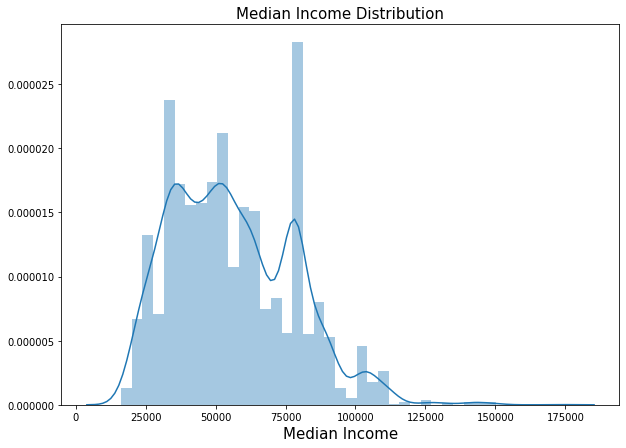

In [6]:
plt.figure(figsize=(10,7))
sns.distplot(yelp_compiled.median_income)
plt.title("Median Income Distribution", fontsize=15)
plt.xlabel('Median Income', fontsize =15);

<Figure size 720x504 with 0 Axes>

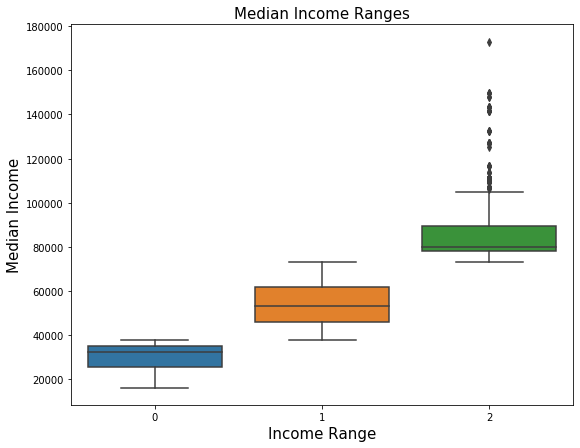

In [7]:
#data =yelp_compiled.income_range.value_counts()
plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize = (9,7))
sns.boxplot(x = 'income_range', y = 'median_income', data = yelp_compiled)
plt.title("Median Income Ranges", fontsize=15)
plt.xlabel("Income Range", fontsize = 15)
plt.ylabel("Median Income",fontsize =15);


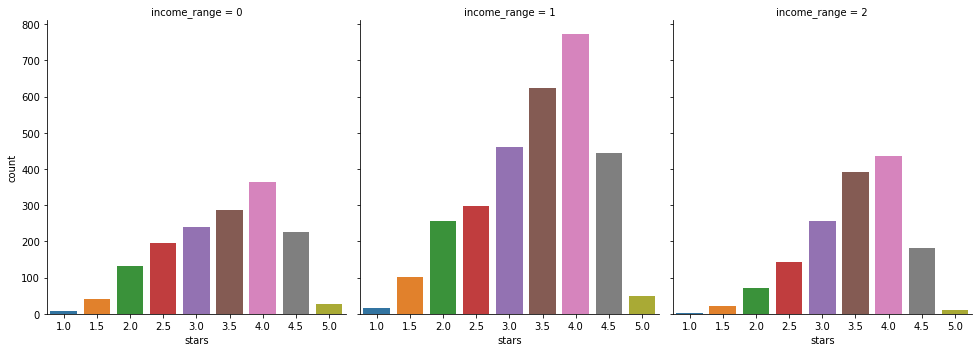

In [8]:
#Distribution of stars
g = sns.catplot(x="stars", col="income_range",
                data=yelp_compiled, kind="count",
                height= 5, aspect=.9);

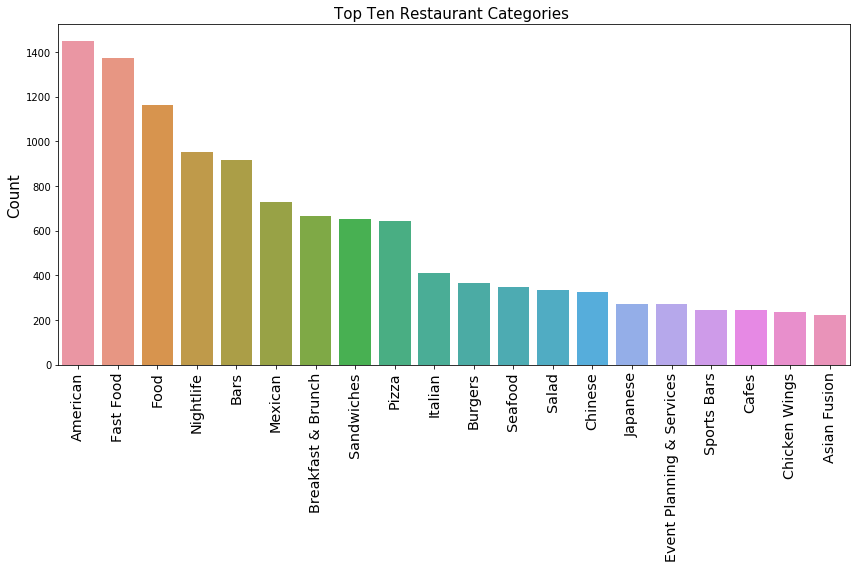

In [9]:
#plotting
categories_sorted =top_categories.sort_values(by ='Count', ascending =False).head(20)
plt.figure(figsize=(12,8))
sns.barplot(x='Category',y='Count',data= categories_sorted) 
plt.title("Top Ten Restaurant Categories ", fontsize=15)
plt.xlabel("")
plt.ylabel("Count",fontsize =15)
plt.xticks(
    rotation= 90, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='x-large')
plt.tight_layout();
# top_categories.sort_values(by ='Count', ascending =False).head(20).plot.bar(x='Category', y ='Count');

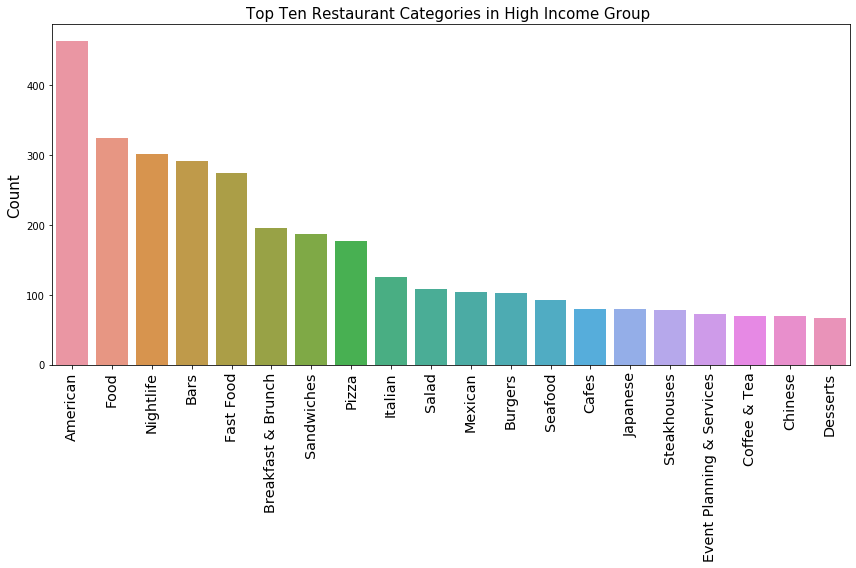

In [10]:
#plotting
categories_sorted_h =categories_high.sort_values(by ='Count', ascending =False).head(20)
plt.figure(figsize=(12,8))
sns.barplot(x='Category',y='Count',data= categories_sorted_h) 
plt.title("Top Ten Restaurant Categories in High Income Group ", fontsize=15)
plt.xlabel("")
plt.ylabel("Count",fontsize =15)
plt.xticks(
    rotation= 90, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='x-large')
plt.tight_layout();


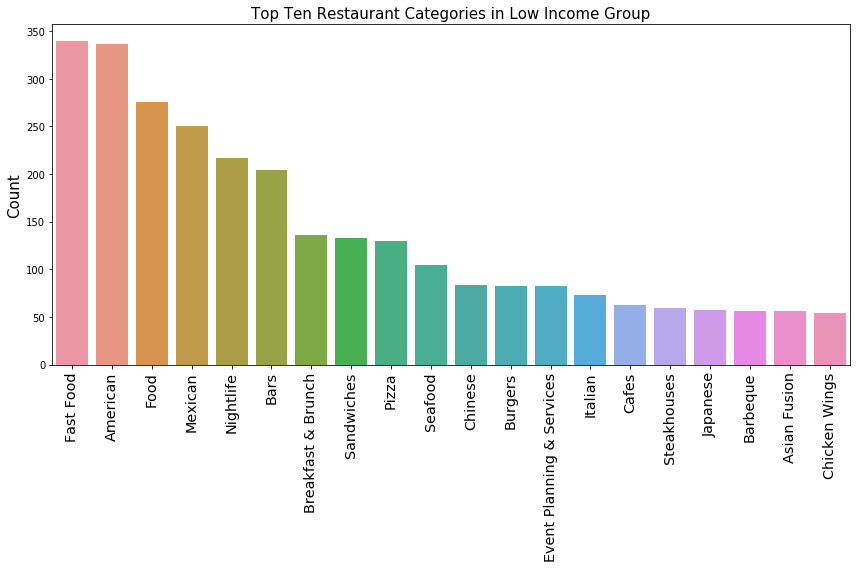

In [11]:
#plotting
categories_sorted_l =categories_low.sort_values(by ='Count', ascending =False).head(20)
plt.figure(figsize=(12,8))
sns.barplot(x='Category',y='Count',data= categories_sorted_l) 
plt.title("Top Ten Restaurant Categories in Low Income Group", fontsize=15)
plt.xlabel("")
plt.ylabel("Count",fontsize =15)
plt.xticks(
    rotation= 90, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='x-large')
plt.tight_layout();

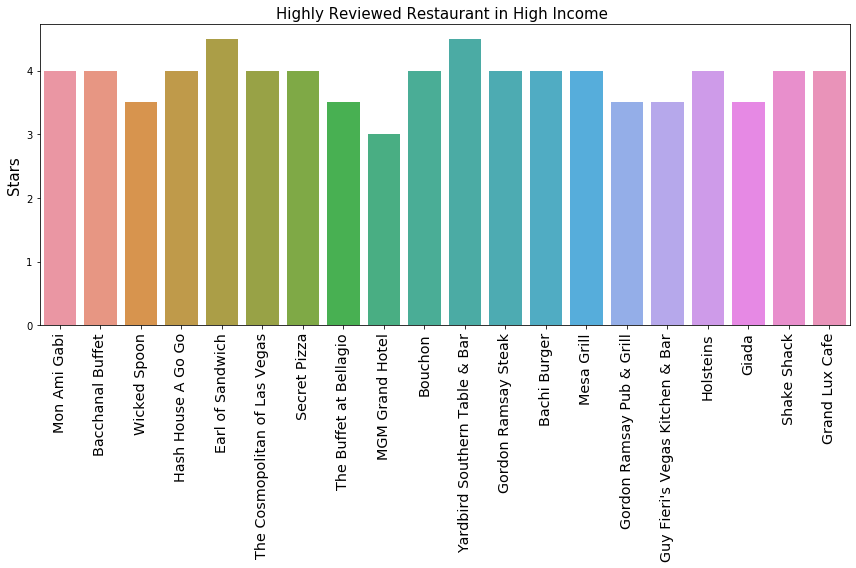

In [12]:
#Highly Reviewed restaurant in high income
income_high_res =income_high.sort_values(by = ['review_count','stars'], ascending =False).head(20)
plt.figure(figsize=(12,8))
sns.barplot(x='name',y= 'stars',data= income_high_res)
plt.title("Highly Reviewed Restaurant in High Income ", fontsize=15)
plt.xlabel("")
plt.ylabel("Stars",fontsize =15)
plt.xticks(
    rotation= 90, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='x-large')
plt.tight_layout();

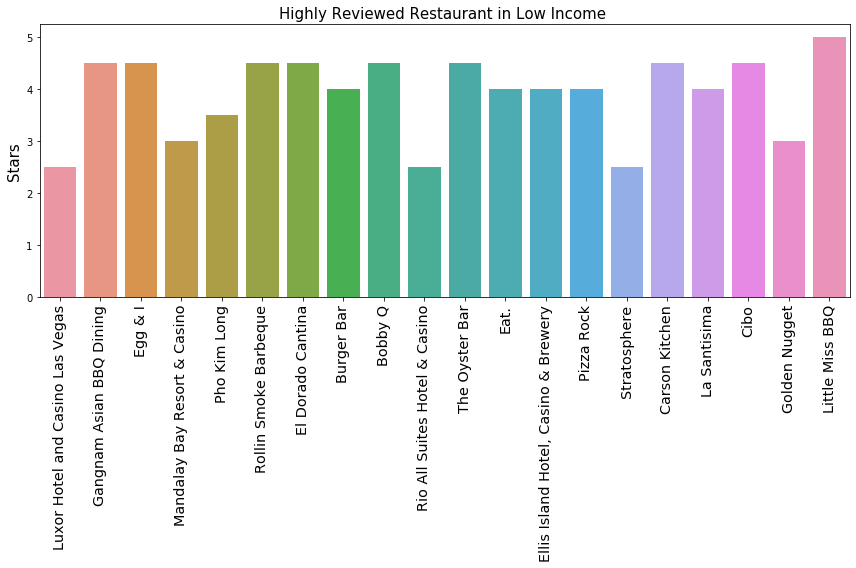

In [13]:
#in low
income_low_res =income_low.sort_values(by = ['review_count','stars'], ascending =False).head(20)
plt.figure(figsize=(12,8))
sns.barplot(x='name',y= 'stars',data= income_low_res)
plt.title("Highly Reviewed Restaurant in Low Income ", fontsize=15)
plt.xlabel("")
plt.ylabel("Stars",fontsize =15)
plt.xticks(
    rotation= 90, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='x-large')
plt.tight_layout()
plt.savefig('Highly_reviewed', dpi = 250);

In [14]:
# Density of restaurants based upon Ambience
from ipywidgets import interact
@interact(y = ['restaurant_density', 'romantic', 'intimate', 'touristy', 'hipster', 'divey', 'classy', 'trendy', 'upscale', 'casual'])
def make_scatter(y):
    yelp_compiled_tract.plot(kind = 'scatter', x = 'median_income', y = y);

interactive(children=(Dropdown(description='y', options=('restaurant_density', 'romantic', 'intimate', 'touris…

In [15]:
yelp_compiled_tract[yelp_compiled_tract['restaurant_density']> 20]

,census_tract,city,review_count,stars,business,price_range,romantic,intimate,touristy,hipster,divey,classy,trendy,upscale,casual,median_income,pop_2018,american,asian_fusion,bakeries,barbeque,bars,beer,breakfast_&_brunch,buffets,burgers,cafes,caterers,chicken_wings,chinese,cocktail_bars,coffee_&_tea,delis,desserts,diners,fast_food,italian,japanese,juice_bars_&_smoothies,lounges,mexican,nightlife,pizza,pubs,salad,sandwiches,seafood,soup,specialty_food,sports_bars,steakhouses,sushi_bars,thai,vegan,vegetarian,wine_&_spirits,wine_bars,ethnic_food,weighted_star,restaurant_density,income_range,ranking,average_review
311,67.000000,Las Vegas,271743,3.491117,394,2.205584,0.038071,0.022843,0.156091,0.007614,0.005076,0.137056,0.170051,0.129442,0.598985,78250.000000,758,0.307107,0.053299,0.025381,0.012690,0.263959,0.010152,0.111675,0.040609,0.068528,0.063452,0.015228,0.025381,0.060914,0.050761,0.060914,0.022843,0.060914,0.022843,0.096447,0.111675,0.055838,0.010152,0.043147,0.058376,0.274112,0.093909,0.022843,0.040609,0.083756,0.106599,0.010152,0.002538,0.043147,0.093909,0.038071,0.005076,0.005076,0.007614,0.010152,0.025381,0.015228,1013784.000000,51.978892,2,1643.085900,689.703046


In [16]:
from ipywidgets import interact
@interact(y = [ 'american',
 'asian_fusion', 'bakeries', 'barbeque', 'bars', 'beer', 'breakfast_&_brunch', 'buffets', 'burgers', 'cafes', 'caterers', 'chicken_wings', 'chinese',
 'cocktail_bars', 'coffee_&_tea', 'delis', 'desserts', 'diners', 'fast_food', 'italian', 'japanese', 'juice_bars_&_smoothies', 'lounges',
 'mexican', 'nightlife', 'pizza', 'pubs', 'salad', 'sandwiches', 'seafood', 'soup', 'specialty_food', 'sports_bars', 'steakhouses', 'sushi_bars',
 'thai', 'vegan', 'vegetarian', 'wine_&_spirits', 'wine_bars', 'ethnic_food'])
def make_scatter(y):
    yelp_compiled_tract.plot(kind = 'scatter', x = 'median_income', y = y);

interactive(children=(Dropdown(description='y', options=('american', 'asian_fusion', 'bakeries', 'barbeque', '…

# Location based Recomender

In [ ]:
px.scatter_mapbox(vegas_geo, lat="latitude", lon="longitude", color="cluster", 
                  hover_data= ['name', 'census_tract', 'income_range','category'], width=1200, height=800 )

In [ ]:
recommender(vegas_ranked,-115.061403,  36.131594)

In [ ]:
recommender(vegas_ranked,-115.240092,  36.2144713)

In [ ]:
recommender(vegas_ranked,-115.172342,  36.103530)

# Model

In [ ]:
feature_cols = yelp_compiled_tract.columns.drop([ 'city', 'census_tract', 'median_income', 'income_range'])

In [ ]:
X= yelp_compiled_tract[feature_cols]
y= yelp_compiled_tract['income_range']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size =0.3, random_state = 321)
scaler = StandardScaler()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [ ]:
%time
clf= LogisticRegression(solver='lbfgs',multi_class='multinomial')
clf.fit(X_train, y_train)


In [ ]:
probas = clf.predict_proba(X_train)
preds = clf.predict(X_train)

In [ ]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

In [ ]:
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
# Print Classification report to look at precision, recall and f1 score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))


In [ ]:
#Over sampler
oversampler = RandomOverSampler(random_state = 321)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
clf.fit(X_resampled, y_resampled)

In [ ]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
# print confusion matrix and plot the heatmap 
log_mod_cm = confusion_matrix(y_test,y_pred)
print(log_mod_cm)
# plot confusion matrix
sns.set(rc={'figure.figsize':(8,6)}, font_scale=2)
ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt='g', linewidths=.5, cmap='coolwarm'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.tight_layout()

In [ ]:
#feature Importance
full_col_names = list(feature_cols.values)
features = pd.DataFrame(clf.coef_[0], index =feature_cols.values, columns = ['importance']).sort_values('importance', ascending=False)
features = features.reset_index().rename(columns = ({'index':'feature'}))
# selecting top 15 and bottom 15 
top15 = features.head(15)
bottom15 =features.tail(15)
top_features = pd.concat([top15,bottom15])

In [ ]:
# plot the classifiers to visualize the class imbalance. 
sns.set(rc={'figure.figsize':(15,8)}, font_scale=1.6)
sns.set_style("ticks")
sns.barplot(top_features.importance, top_features.feature, alpha=1)
plt.title('Logmod Feature Importance', fontsize = 20)
plt.ylabel('Features', fontsize=20)
plt.xlabel('Feature Importance', fontsize=20)
plt.yticks(fontsize = 15)
plt.tight_layout()

In [ ]:
from IPython.display import Image

In [ ]:

fig = px.scatter(yelp_compiled_tract, x="stars", y="median_income", color ="city", trendline="ols", labels ={ "wins":'Wins Percentage',"total_salary": "Salary per Team","year_bins": "Year Range"},
                 title ="Corelation Between Stars and Median Income ")
fig.show()

# Word Cloud 

In [ ]:
most_frequent_badreviews = count_ngrams(badreviews_only,max_length=3)
%time
print_word_cloud(most_frequent_badreviews, 10)

In [ ]:
print_most_frequent(most_frequent_badreviews, num= 10)

In [ ]:
most_frequent_goodreviews = count_ngrams(goodreviews_only,max_length=3)
print_word_cloud(most_frequent_goodreviews, 10)

In [ ]:
print_most_frequent(most_frequent_goodreviews, num= 10)

In [ ]:
most_frequent_low_goodreviews = count_ngrams(low_goodreviews_only,max_length=3)
print_word_cloud(most_frequent_low_goodreviews, 10)

In [ ]:
print_most_frequent(most_frequent_low_goodreviews, num= 10)

In [ ]:
# fig = px.scatter(yelp_compiled_tract, x="stars", y ='median_income', facet_col = "income_bins",color ="city")
# #                 title ="Total Salary Over The Years : 2000 - 2016")
# fig.show()